In [15]:
%matplotlib inline

import time
from math import exp
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import StringIO, pydot
from IPython.display import Image as Im
from IPython.display import display

from sklearn.linear_model import Ridge
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import mean_absolute_error

FIGSIZE = (11, 7)

# Lecture 9: Decision Tree Methods

We now show you tree-based methods for regression and classification. These involve stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. These method get their name from the fact that we obtain a set of splitting rules to segment the predictor space which can be summarized in a tree.

These methods, although useful for interpretation, are not as competitive as the methods from the last lectures. So we will talk about:

* bagging
* random forests
* boosting

which involve producing multiple trees which are then combined to get a single predictor. These methods will dramatically improve the accuracy of these methods at the expense of interpretation.

## Basics: Regression Trees

To motivate Regression Trees let us load up the `Hitters` data to predict a baseball player’s `Salary` based on `Years` and `Hits`. We first first remove observations that are missing and log-transform `Salary` so that its distribution has more of a typical bell-shape:

In [16]:
hitters_df = pd.read_csv("../data/Hitters.csv", index_col ='Name')
hitters_df.dropna(inplace=True)
hitters_df['log_salary'] = np.log(hitters_df.Salary)
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,log_salary
Name,,,,,,,,,,,,,,,,,,,,,
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,...,414,375,N,W,632,43,10,475.0,N,6.163315
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,...,266,263,A,W,880,82,14,480.0,A,6.173786
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,...,838,354,N,E,200,11,3,500.0,N,6.214608
Andres Galarraga,321,87,10,39,42,30,2,396,101,12,...,46,33,N,E,805,40,4,91.5,N,4.516339
Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,...,336,194,A,W,282,421,25,750.0,A,6.620073


(-0.17435292027769778,
 25.172193555247681,
 -10.908353939978319,
 249.90641609643438)

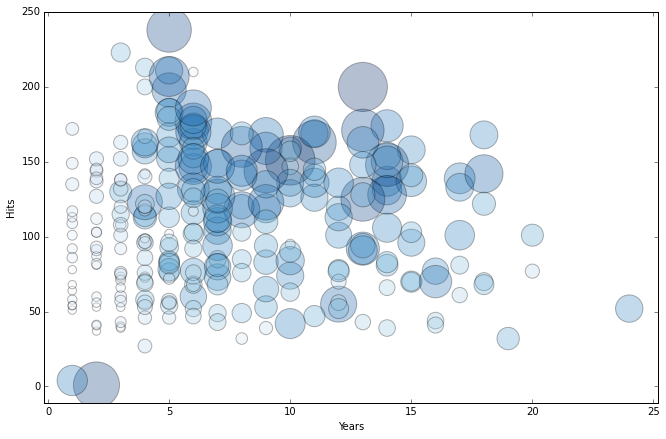

In [17]:
plt.figure(figsize=FIGSIZE)
plt.scatter(hitters_df.Years, hitters_df.Hits,
            s = hitters_df.Salary, 
            c = hitters_df.log_salary, 
            cmap=cm.Blues, alpha=0.3)
plt.xlabel("Years")
plt.ylabel("Hits")
plt.axis("tight")

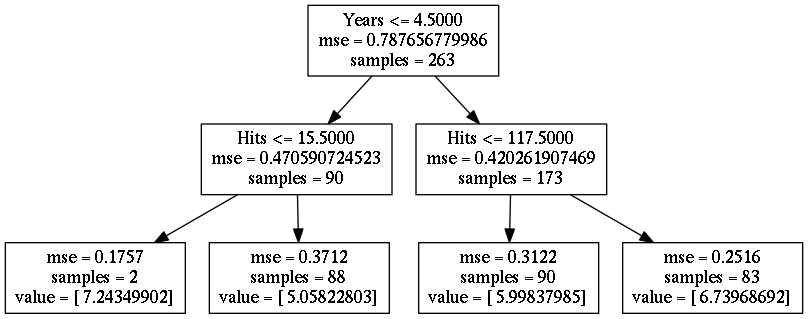

In [18]:
est = DecisionTreeRegressor(max_depth=2)
X = hitters_df[["Hits", "Years"]]
y = hitters_df["log_salary"]
est.fit(X, y)
dot_data = StringIO.StringIO()
export_graphviz(est, out_file=dot_data,feature_names=["Hits","Years"])
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Im(graph.create_png())

The figure above represents a series of splitting rules. The top split assigns oberservations as having `Year <= 4.5` to the left of the branch. The predicted salary is further split on `Hits <= 15.5` to the left. And so for any player now we can predict their salary by spliting their two features by this rule to obtain their mean log salary.

In keeping with the tree analogy, the various splitted regions are known as terminal nodes or leaves of a tree.

Ignoring for now the two out-liers, we might interpret the regression tree as follows: `Years` is the most important factor in determining `Salary` and players with less experience earn lower salaries than more experienced players. Given that a player is less experienced the number of hits that he made in the previous year seems to play little role in his salary.  But among players who have been in the major leagues for five or more years, the number of hits made in the previous year does affect salary, and players who made more hits last year tend to have higher salaries. This is likely an over-simplification of the true relationship between `Hits`, `Years` and `Salary`.

## Prediction via Stratification of the Feature Space

To build a regression tree we follow the two following steps:

1. We divide the predictor space the set of values for $X_1, X_2,...,X_p$ into $J$ distinct non-overlapping regions $R_1,R_2,...,R_J$
2. For each observation that falls in $R_j$, we predict the  mean of the response values for the training observations in $R_j$


How do we construct these regions? They could be any shape. We however choose to divide the space into rectangles and the goal is to find the boxes $R_1,R_2,...R_J$ that minimise the RSS:
$$
\sum_{j=1}^{J}\sum_{i\in R_j} (y_i - \hat{y}_{R_j})^2,
$$

where $\hat{y}_{R_j}$ is the mean reposonse for the training observations in the region $R_j$.  To split we take a top-down greedy apprach: begin at the top tree or the whole region and successively split the space. It is greedy because at each step of the process the best split is made at that particular step, instead of looking ahead and picking a split that will lead to a better tree in some further step.

So we define for some $X_j$ a split at a cut point $s$ as $\{X| X_j < s \}$ and $\{ X| X_j \ge s\}$ the region of predictor space where it takes values less than or greater than some $s$. Then we consider all features $X_1,...,X_p$ all possible values of $s$ for each predictor and then choose the predictor and $s$ for which the resulting tree has the lowest RSS.

Formally if
$$
R_1(j,s) = \{X| X_j < s \} \quad \mathrm{and}\quad R_2(j,s) = \{X| X_j \ge s \}
$$
are the two half planes then we want values of $j$ and $s$ that minimise:
$$
\sum_{i: x_i \in R_1(j,s)}  (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j,s)}  (y_i - \hat{y}_{R_2})^2,
$$
which is relatively quick if $p$ is reasonable.

Next we repeat this for each sub-region until all $R_1,...,R_J$ have been created.

## Tree Prunning

This method will likely overfit the data, leading to poor test performance results. This is because the resulting tree might be too complex. A smaller tree on the other hand might lead to lower variance and better interpretation at the cost of a little bias. 

One alternative is to build a tree only so long as the decrease in RSS due to each split exceeds some high threshold. This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split i.e. a split that leads to a large reduction in RSS later on.

A better strategy is to grow a very large tree $T_0$ and then prune it back to get a subtree. How to do this? Given a subtree we can estimate its test error using cross-validation or the validation set approach. Doing this for every possible subtree is too expensive. Instead we can use weak link pruning. We add a penalty parameter $\alpha$ to the number of terminal nodes of a tree. When $\alpha = 0$ we have our orignal tree $T_0$. But as $\alpha$ increases we there is a price to pay for having a tree with many terminal nodes. It is like the Lasso but for trees. We then select the optimal value of $\alpha$ using a validation set or using cross-validation.

## Classification Trees

A classification tree is very similar to a regression tree but for a qualitative response. Here we  predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs. In interpreting the results here we are interested in the class prediction and also in the class propotions among the training observations that fall into that region.

Growing a tree is similar but instead of RSS we use classification error rate: the fraction of the training observations in that region that do not belong to the most common class. But this is not  sufficiently sensitive for tree-growing and in practive we use two other measures. The first is the Gini index:
$$
G = \sum_{k=1}^{K} \hat{p}_{mk}(1-\hat{p}_{mk}),
$$
where $\hat{p}_{mk}$ represents the proportion of training observations in the $m$-th region that are from the $k$-th class. The Gini index is a measure of total variance across the $K$ classes, since it takes on a small value if all the $\hat{p}_{mk}$ are close to 1 or 0. And a small value indicates that a node contains predominantly observations from a single class.

The other alternative is cross-entropy:
$$
D = - \sum_{k=1}^{K} \hat{p}_{mk} \log \hat{p}_{mk}.
$$
Again we can show that  cross-entropy will take on a value near zero if all the $\hat{p}_{mk}$ are all near zero or near one. So it will take on a small value if the $m$-th node is pure. 

## Pros and Cons of Trees

Trees have a number of advantages over the classical approach:
* trees are very easy to explain to people
* trees more closely mirror human decision-making than do the regression and classification
* trees can be displayed graphically
* trees can easily handle qualitative predictors without dummy variables

But there is one disadvantage: trees generally do not have the same level of predictive accuracy as some of  classical methods. However the next sections introduce methods to to substantially this.

## Parameter Tuning

One can use the `GridSearchCV` to find the optimal parameter for these methods in Scikit-Learn. The most important parameters are:
* `max_depth`: the maximum depth of the tree (increases variance)
* `min_samples_leaf`: the minimum number of samples required to be at a leaf node (increases bias)

Best hyperparameters: {'max_features': 1.0, 'max_depth': 4, 'min_samples_leaf': 1}


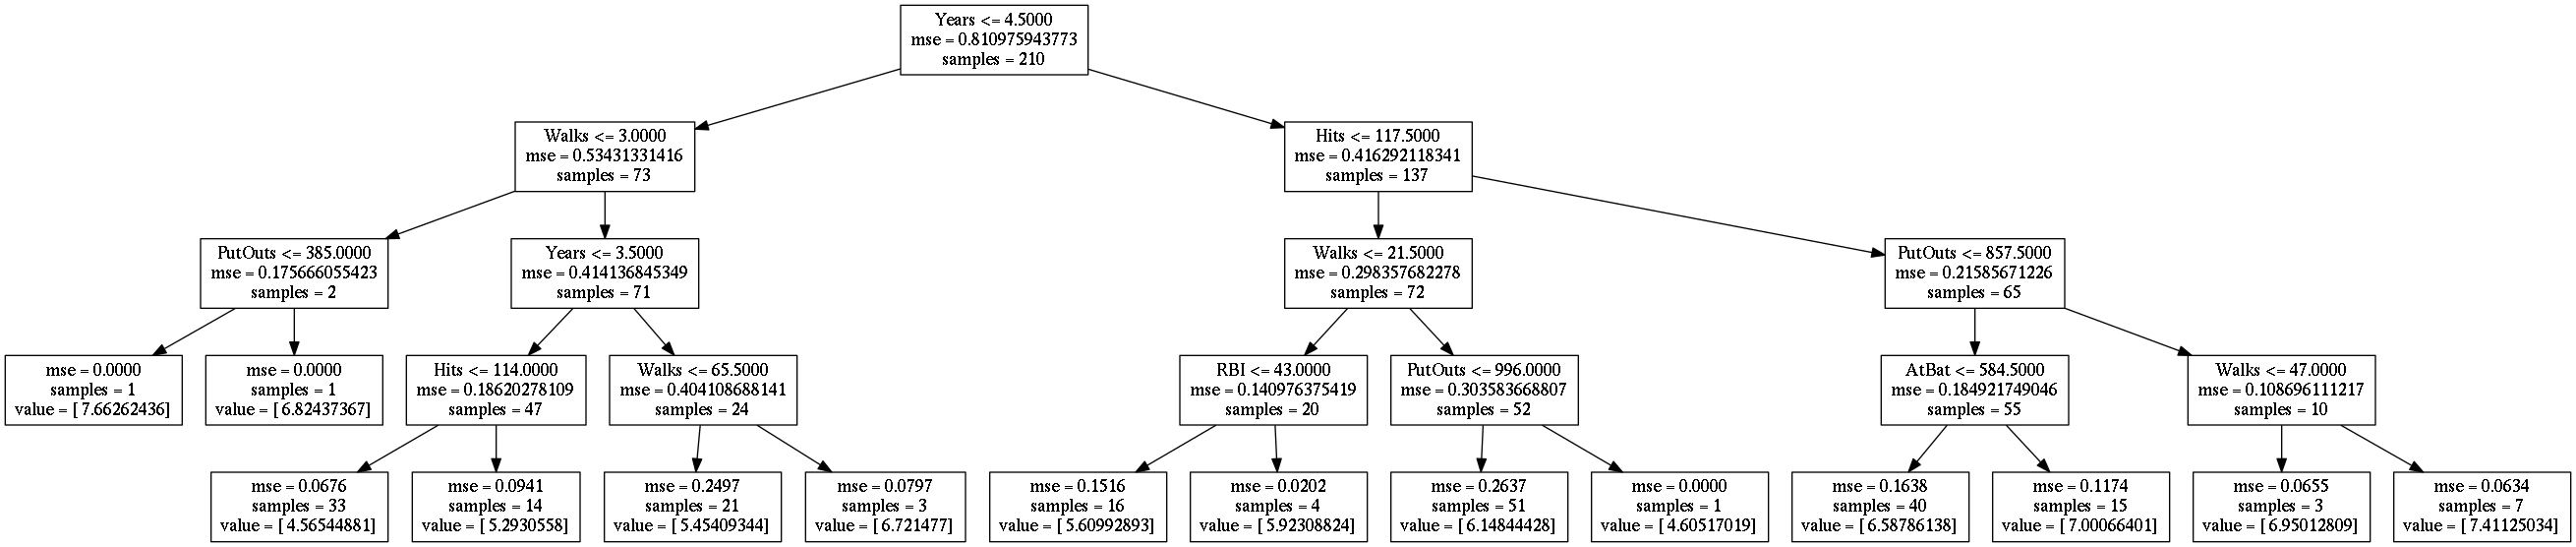

In [19]:
param_grid = {'max_depth': [2, 4, 6, 8],
              'min_samples_leaf': [1, 3, 5, 7],  ## depends on the nr of training examples
              'max_features': [1.0, 0.6, 0.3, 0.1] ## The number of features to consider when looking for the best split
              }
est = DecisionTreeRegressor()
X = hitters_df[["Hits", "Years", "Walks", "Runs", "RBI", "PutOuts", "HmRun", "Assists", "Errors", "AtBat"]]
y = hitters_df["log_salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gs_cv = GridSearchCV(est, param_grid, scoring='mean_squared_error', n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)

# refit model on best parameters
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)
dot_data = StringIO.StringIO()
export_graphviz(est, out_file=dot_data,feature_names=["Hits", "Years", "Walks", "Runs", "RBI", "PutOuts", "HmRun", "Assists", "Errors", "AtBat"])
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Im(graph.create_png())

--- 

## Bagging (Boostrap Aggregation)

Recall the bootstrap idea where it was used in many situations in which it is hard or even impossible to directly compute the standard deviation of a statitic of interest. We will use this idea in the context of trees. 

The previous methods suffer from high variance: if we split the training data into two parts at random and fit a decision tree to both halves the results that we get could be quite different. A low variance will give similar results. Linear regression with $n \gg p$ has low variance. So if we can reduce the variance of the tree methods we could potentially increase the power of these methods. Bagging is a general procedure for reducing the variance of a statistical learning method.

Given a set of $n$ independent observations $Z_1,...,Z_n$ each with variance $\sigma^2$  the variance of the mean $\bar{Z}$ is $\sigma^2 /n$. So averaging a set of observations reduces variance. So if we  take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions we can reduce the variance of a model. In other words we could calculate the a separate prediction model ussing $B$ training sets to obtain $\hat{f}^{1}(x),...,\hat{f}^{B}(x)$. Now if we average these we will get a low-variance model:
$$
\hat{f}_{avg}(x) = \frac{1}{B}\sum_{b=1}^{B} \hat{f}^{b}(x).
$$

But this is not practical since we do not multiple training sets, so instead we can boostrap by repeated sampling with replacement to generate $B$ training sets. We then train our method on the $b$-th  bootstrapped training set in order to get $\hat{f}^{*b} (x)$ and then average them all:
$$
\hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^{B} \hat{f}^{*b}(x).
$$

While this is useful for general methods it is particularly useful for regression trees. We construct $B$ regression trees using $B$ bootstrapped training sets and average the resulting predictions. These trees are grown deep and not pruned. Hence each individual tree has high variance and low bias and averaging them reduces the variance.

What about classification problems? Well the simplest approach is to  record the class predicted by each of the $B$ trees and take a majority vote: the overall prediction is the most commonly occurring class among the $B$ predictions.

Scikit-learn provides two estimators for bagging: `BaggingClassifier` and `BaggingRegressor` both of which are in the `sklearn.ensemble` package. Estimators support arguments to control the fitting behaviour via hyper-parameters and here the most important are:
* `n_estimators`: number of regression trees $B$

In [20]:
# generate synthetic data
X, y = make_hastie_10_2(n_samples=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit estimator
est = BaggingClassifier(n_estimators=200)
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

ACC: 0.8624


array([ 0.29,  0.71])

### Function approximation

Let us generate a Sinoide function with random noise and a 80/20 training/test split:

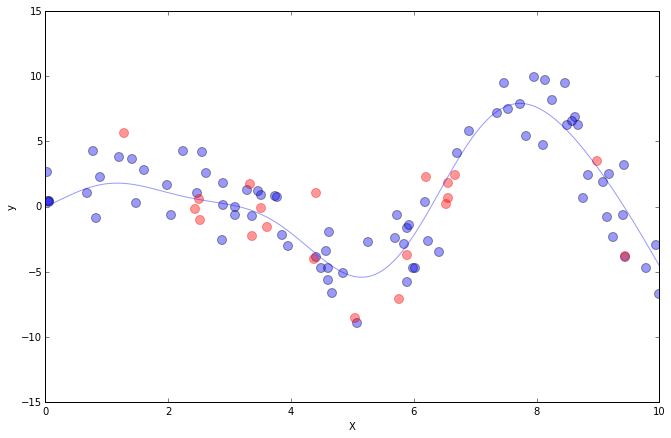

In [21]:
def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    X = np.random.uniform(0, 10, size=n_samples)[:, np.newaxis]
    y = ground_truth(X.ravel()) + np.random.normal(scale=2, 
                                                   size=n_samples)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(100)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(alpha=0.4, s=80):
    fig = plt.figure(figsize=FIGSIZE)
    gt = plt.plot(x_plot, ground_truth(x_plot), 
                  alpha=alpha, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=s, alpha=alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('X')
    
annotation_kw = {'xycoords': 'data', 'textcoords': 'data',
                 'arrowprops': {'arrowstyle': '->', 'connectionstyle': 'arc'}}
    
plot_data()

### Regression Trees

The deeper the tree the more variance can be explained. The depth of the trees control model complexity and this obviously comes at a price of overfitting:

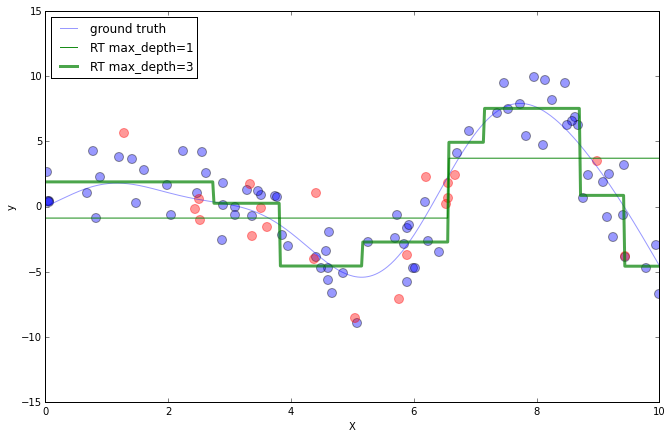

In [22]:
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=1)

est = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=3)

plt.legend(loc='upper left')

### Bias-Variance for Tree Methods

In order to calculate the bias and variance of the regression tree and compare it to that from bagging, we will need to repeat the above a number of times in order to estimate the variance of the predictions. Here we model the various statistics by first generating data for 50 simulations and then fitting the trees to a depth of 4. Finally we plot the trees as well as the variance and see that Bagging does indeed reduce the variance:

Reg. Tree: 6.8301 (error) = 0.0757 (bias^2)  + 2.7402 (var) + 3.9291 (noise)
Bagging(Tree): 5.8215 (error) = 0.0882 (bias^2)  + 1.7136 (var) + 3.9291 (noise)


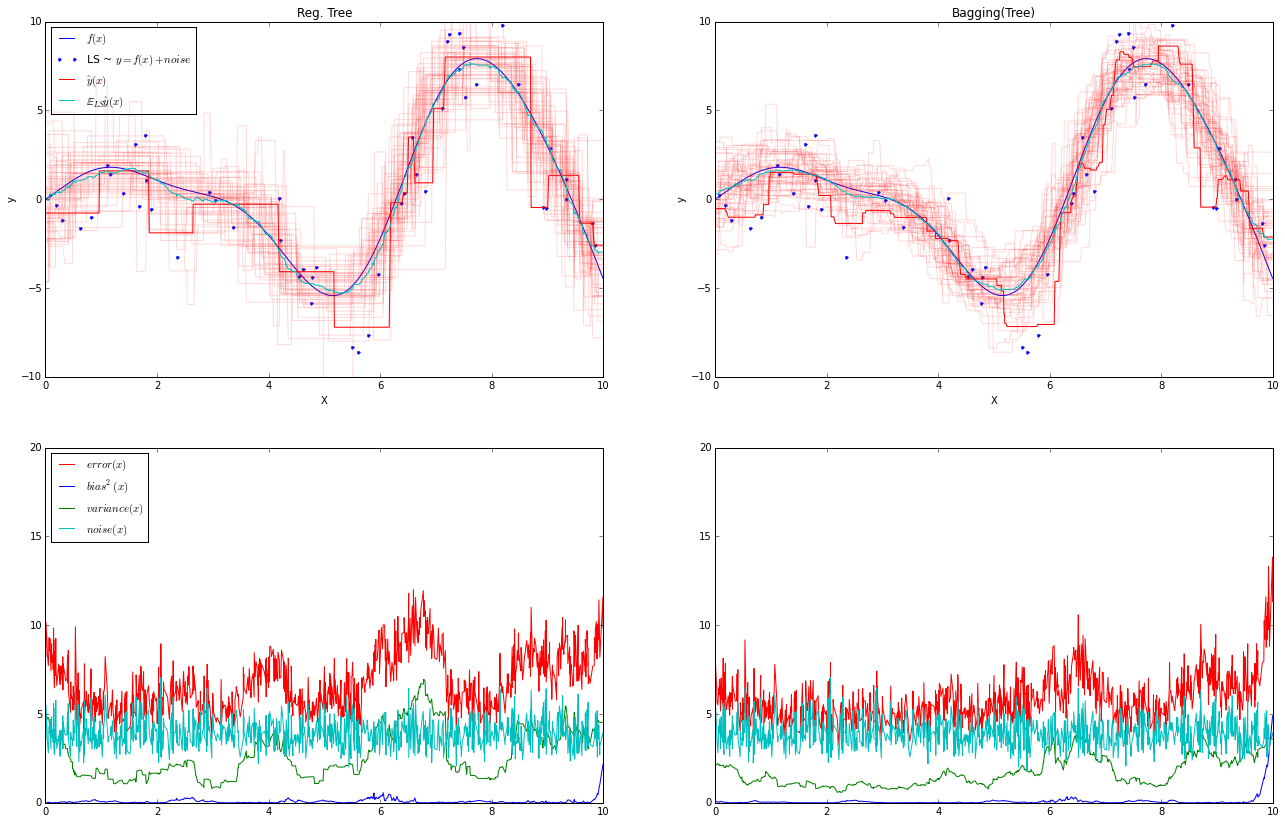

In [23]:
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set


estimators = [("Reg. Tree", DecisionTreeRegressor(max_depth=4)),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor(max_depth=4)))]
n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()
    return x * np.sin(x) + np.sin(2 * x)

def generate(n_samples, n_repeat=1):
    X = np.random.uniform(0, 10, size=n_samples)
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(scale=2, size=n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(scale=2, size=n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, n_repeat=n_repeat)

# Loop over estimators to compare
fig = plt.figure(figsize=(22, 14))
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in xrange(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.15)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([0, 10])
    plt.ylim([-10, 10])
    plt.ylabel('y')
    plt.xlabel('X')
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([0, 10])
    plt.ylim([0, 20])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()

### Out-of-Bag Error Estimation

There is also a straighforward way to  estimate the test error of a bagged model, without the need to perform cross-validation or the validation set approach. Again:  key to bagging is that trees are repeatedly fit to bootstrapped subsets of the observations. One can show that on average, each bagged tree makes use of around two-thirds of the observations. The remaining one-third of the observations not used to fit a given bagged tree are referred to as the out-of-bag (OOB) observations. This left out portion can be used to estimate the generalization error without having to rely on a separate validation set. This estimate comes "for free" as no additional data is needed and can be used for model selection.

In Scikit-Learn these estimates are implemented as `oob_score_` and `oob_decision_function_` which remember are the states of the estimators stored as instance attributes and end with a trailing underscore.

---

## Random Forests

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees.  As in bagging, we build a number of decision trees on bootstrapped training samples.  But when building these decision trees, each time a split in a tree is considered,   a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those $m$ predictors. A fresh sample of  $m$ predictors is taken at each split, and typically we choose  $m \approx \sqrt{p}$ i.e. the number of predictors considered at split is approximately equal to the  square root of the total number of predictors.

So when building a random forest at each split in the tree, the algorithm is not even allowed to consider a majority of the available predictors. This may sound mad, but there is a clever reason behind this. Suppose that there is one very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of bagged trees most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look quite similar to each other. Hence the predictions from the bagged trees will be highly correlated.  But averaging many highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities. So bagging will not lead to a big reduction in variance over a single tree in this setting.

Random forests overcome this problem by forcing each split to consider only a subset of the predictors.  Thus on average $(p-m)/p$ of the splits will not even consider the strong predictor and so other predictors will have more of a chance. This is what we mean by decorrelating the trees.

The main difference between bagging and Random forest is the choice of the predictor subset size $m$. If $m=p$ in Random forest we are just doing bagging. Using a small value of $m$ will typically be helpful when we have a large number of correlated predictors.

### California Housing

Scikit-Learn comes with California housing data consisting of 20,000 groups with 8 features: median income, average house age, coordinates etc. and we want to predict the meadian house value for a census block.

In [24]:
cal_housing = fetch_california_housing()

# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2)
names = cal_housing.feature_names

And this data is challenging to work with since it has heterogenous features (different scales and distributions, see plot below), non-linear feature interactions (interaction: latitude and longitude) and extreme responses for which one  needs robust regression techniques.

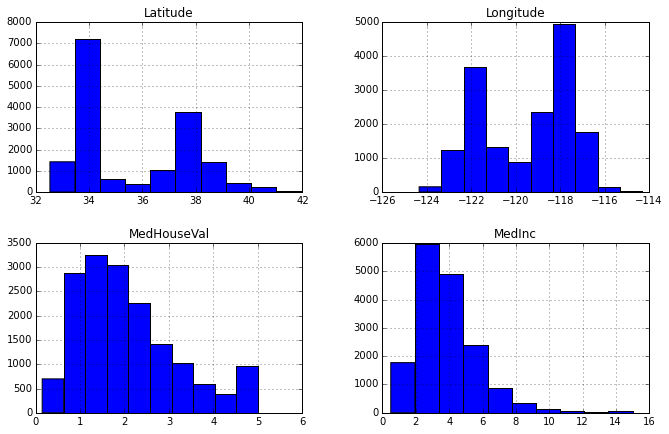

In [25]:
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['MedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'], figsize=FIGSIZE)

Let us define a `benchmark()` helper:

In [26]:
res = defaultdict(dict)

def benchmark(est, name=None):
    if not name:
        name = est.__class__.__name__
    t0 = time.clock()
    est.fit(X_train, y_train)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = est.predict(X_test)
    res[name]['test_time'] = time.clock() - t0
    res[name]['MAE'] = mean_absolute_error(y_test, pred)
    return est

In [27]:
benchmark(Ridge(alpha=0.0001, normalize=True))
benchmark(DecisionTreeRegressor(max_features=5))
benchmark(BaggingRegressor(DecisionTreeRegressor(max_features=5)))
est = benchmark(RandomForestRegressor(n_estimators=100, 
                                      max_features=5, 
                                      bootstrap=False, n_jobs=4))
res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'MAE']].sort('MAE', ascending=False)

,train_time,test_time,MAE
Ridge,0.017538,0.000558,0.539979
DecisionTreeRegressor,0.277197,0.003566,0.473304
BaggingRegressor,1.532892,0.034795,0.345993
RandomForestRegressor,35.853998,0.680636,0.319145


### Variable Importance Measures

One advantage of why descision trees are attractive is the easily interpreted diagram. However, when we bag a large number of trees it is no longer possible to represent the resulting statistical learning procedure using a single tree, and it is no longer clear which variables are most important to the procedure. Thus bagging methods improve prediction accuracy at the expense of interpretability.

One can however obtain an overall summary of the importance of each predictor using the RSS (for bagging regression) or the Gini index (for bagging classification trees). In Scikit-Learn this can be accessed via the attribute `feature_importances_`:

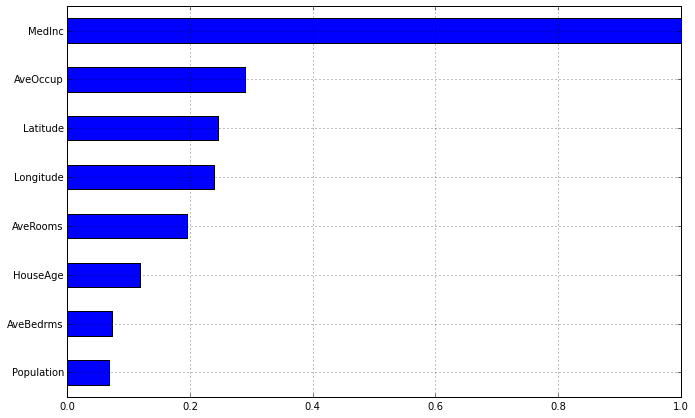

In [28]:
fx_imp = pd.Series(est.feature_importances_, index=names)
fx_imp /= fx_imp.max()  # normalize
fx_imp.sort()
fx_imp.plot(kind='barh', figsize=FIGSIZE)

--- 

## Boosting

Now let us discus yet another approach for improving the prediction resulting from a decision tree. Like bagging, boosting is a gernal approach that can be applied  to many statistical learning methods. Here we only talk about boosting in the context of descision trees.

Bagging  involves creating multiple copies of the original training data using bootstrap, fitting a seperate tree to each copy and then combining all the trees in order to create a single predictive model. Each tree is built on a bootstrap sample set independent of the other trees. Boosting works similarly but the trees are grown sequencially: each tree is grown using information from previously grown tree. Boosting does not involve bootstrap sampling, instead each tree is fit on a modified version of the original data set.

The algorithm for boosting is:
1. Set $\hat{f}(x)=0$ and $r_i = y_i$ for all $i$ in training set
2. For $b=1,...,B$ repeat:
  * Fit a tree $\hat{f}^b$ with $d$ splits ($d+1$ terminal nodes) to the training data $(X,r)$
  * Update $\hat{f}$ by adding in a shrunken version of the new tree: $$ \hat{f}(x) := \hat{f}(x) + \lambda \hat{f}^b(x)$$
  * Update the residuals: $$ r_i := r_i - \lambda \hat{f}^b(x_i) $$
3. Output the boosted model: $$ \hat{f}(x) = \sum_{b=1}^{B} \lambda  \hat{f}^b(x) $$

What is the idea behind this procedure? Unlike fitting a single large decision tree to the data which amounts to fitting the data hard and potentially overfitting, the boosting method instead learns slowly.

Given the current model we fit a decision tree to the residuals from the model: i.e. we fit a tree using the current residuals, rather than the outcome $Y$ the response.  We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes given by the $d$ in the algorithm.

By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down even more allowing more and different shaped trees to attack the residuals.

Boosting has three hyper-parameters:
1. the number of trees $B$: boosting can overfit if $B$ is too large but use CV to select $B$
2. the shrinkage parameter $\lambda$: very small $\lambda$ can require using a large $B$ for good performance
3. the number of splits $d$: often $d=1$ works well which is a single split, but often $d$ is the interaction depth and controls the interaction order of the boosted model since $d$ splits can involve at most $d$ features

### Gradient Boosted Regression Trees

These methods can be generalised to different loss functions and Gradient Boosting minimises the loss function via an iterative Gradient Descent procedure. In Scikit the `GradientBoostingRegressor` has these important parameters:
* `n_estimators`: controls the number of trees $B$
* `learning_rate`: the shrinkage parameter $\lambda$

Typically we use a Deviance plot to determine if the model is overfitting. Recall Deviance was an indication of the model fit to the training data and we can get it via the `est.train_score_`. The test error can also be calculated via `est.staged_predict()`. Here is a helper function to plot a deviance plot as a function of the number of trees or model complexity:

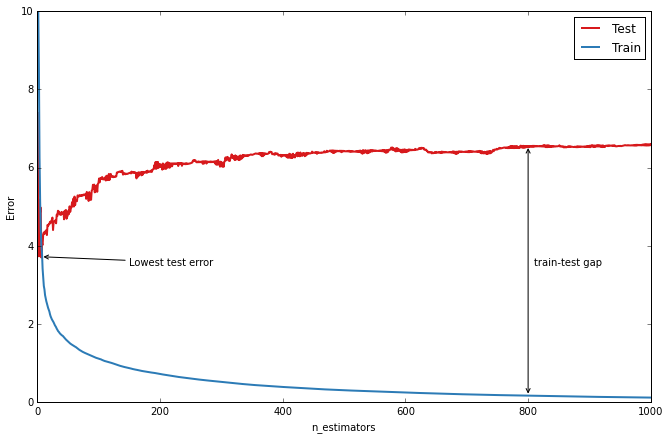

In [29]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=FIGSIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

X_train, X_test, y_train, y_test = gen_data(100)

est = GradientBoostingRegressor(n_estimators=1000, 
                                max_depth=1, 
                                learning_rate=1.0)
est.fit(X_train, y_train)

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02),
            xytext=(150, 3.5), **annotation_kw)

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops={'arrowstyle': '<->'})
ax.text(810, 3.5, 'train-test gap')

A large test-train gap indicates  that the model is overfitting. Gradient Boosted Regression Trees has a number of regularisation hyper-parameters to control overfitting:
* `max_depth`:  controls the degree of features interactions 
* `min_samples_leaf`: to make sure there are sufficient number of samples per leaf

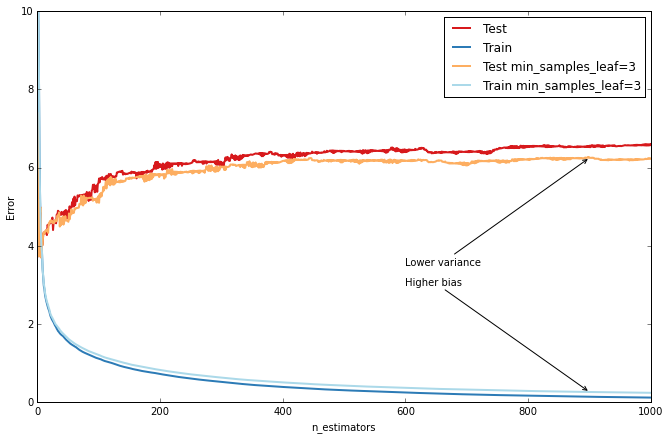

In [30]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.iteritems())

fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, 
                                    learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xytext=(600, 3), **annotation_kw)
ax.annotate('Lower variance', xy=(900, test_dev[899]), xytext=(600, 3.5), **annotation_kw)
plt.legend(loc='upper right')

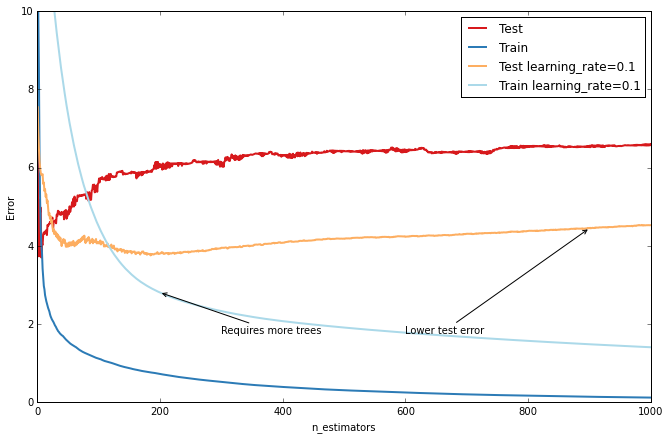

In [31]:
ig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), 
            xytext=(300, 1.75), **annotation_kw)
ax.annotate('Lower test error', xy=(900, test_dev[899]),
            xytext=(600, 1.75), **annotation_kw)
plt.legend(loc='upper right')

Other hyper-parameters include:
* `subsample`: which subsampling the training set before growing each tree
* `max_features`: which subsampling the features before finding the best split node

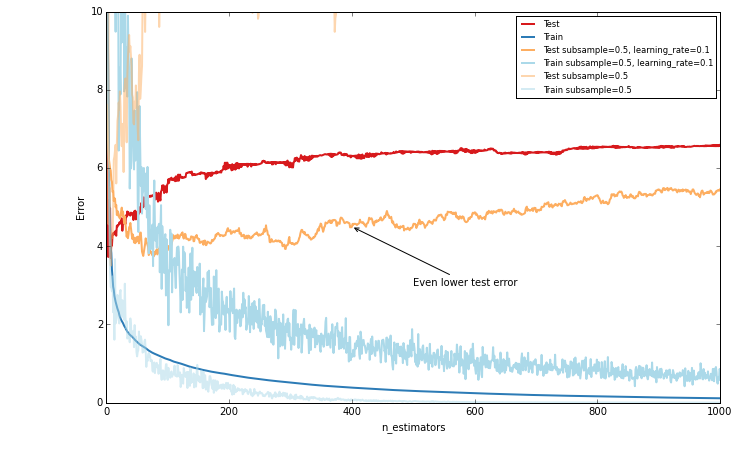

In [32]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 
                                            'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, 
                                    max_depth=1, 
                                    learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]),
            xytext=(500, 3.0), **annotation_kw)

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), 
            xytext=(500, 5.5), **annotation_kw)
plt.legend(loc='upper right', fontsize='small')

### California Housing

Now in class try to use GBRT as the estimator and properly tune it for the California Dataset. First check via the plots above if you are in a high-bias or high-variance regime. Finally what are the important features and how do they contribute in predicting the target response?

In [33]:
# your code here